In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#from IPython.display import clear_output
!pip install imutils
#clear_output()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, keras
import shutil
import cv2

import imutils
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import glob
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

In [4]:
from numpy.random import seed
seed(88)
from tensorflow.random import set_seed
set_seed(88)

In [5]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        img = cv2.imread(img) #original syntax
        #image = load_img(img,
                         #color_mode = 'grayscale')
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #original syntax
        #gray = np.array(image)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

def crop_imgs_array(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.GaussianBlur(img, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

def gray_scale_img(path) :
    for sub_dir in tqdm(os.listdir(path)) :
        for file in os.listdir(path + '/' + sub_dir) :
            src = load_img(path + '/' + sub_dir + '/' + file,
                           color_mode = 'grayscale')
            #src = cv2.imread(path + '/' + sub_dir + '/' + file)
            output = np.array(src)
            cv2.imwrite(path + '/' + sub_dir + '/' + file, output)

In [6]:
#os.listdir('./VAL')
def resize_img_path(path, dsize) :
    for sub_dir in tqdm(os.listdir(path)) :
        for file in os.listdir(path + '/' + sub_dir) :
            src = cv2.imread(path + '/' + sub_dir + '/' + file)
            output = cv2.resize(src, dsize)
            cv2.imwrite(path + '/' + sub_dir + '/' + file,output)

In [7]:
#os.listdir('./VAL')
def resize_img(path, dsize) :
    result = []
    #for sub_dir in tqdm(os.listdir(path)) :
    for file in os.listdir(path) :
        src = cv2.imread(path + '/' + file)
        output = cv2.resize(src, dsize)
        #cv2.imwrite(path + '/' + sub_dir + '/' + file,output)
        result.append(output)
    return np.array(result)

In [8]:
def resize_img_array(data, dsize) :
    result = []
    #for sub_dir in tqdm(os.listdir(path)) :
    for img in data :
        output = cv2.resize(img, dsize)
        result.append(output)
    return np.array(result)

In [9]:
def prob_converter(data) :
    dim = data[0].shape[0]
    result = []
    prob = []
    for i in range(dim) :
        res = []
        res.append(np.mean((data[0][i][0], data[1][i][0], data[2][i][0])))
        res.append(np.mean((data[0][i][1], data[1][i][1], data[2][i][1])))
        res.append(np.mean((data[0][i][2], data[1][i][2], data[2][i][2])))
        res.append(np.mean((data[0][i][3], data[1][i][3], data[2][i][3])))
        prob.append(res)
    prob = np.array(prob)
    
    for i in prob :
        result.append(np.where(i == i.max())[0][0])
    return result

def prob_average(data) :
    dim = data[0].shape[0]
    result = []
    prob = []
    for i in range(dim) :
        res = []
        res.append(np.mean((data[0][i][0], data[1][i][0], data[2][i][0])))
        res.append(np.mean((data[0][i][1], data[1][i][1], data[2][i][1])))
        res.append(np.mean((data[0][i][2], data[1][i][2], data[2][i][2])))
        res.append(np.mean((data[0][i][3], data[1][i][3], data[2][i][3])))
        prob.append(res)
    prob = np.array(prob)
    
    return prob

In [10]:
IMG_PATH = '../input/brain-mri-os'
#for Class in os.listdir(IMG_PATH) :
#    print(Class)
print('glioma_tumor : ' + str(len([file for file in os.listdir('../input/brain-mri-os/Training fix/glioma_tumor_fix')])))
print('meningioma_tumor : ' + str(len([file for file in os.listdir('../input/brain-mri-os/Training fix/meningioma_tumor_fix')])))
print('hipofisis tumor : ' + str(len([file for file in os.listdir('../input/brain-mri-os/Training fix/pituitary_tumor_fix')])))
print('no tumor : ' + str(len([file for file in os.listdir('../input/brain-mri-os/Training fix/no_tumor_fix')])))

glioma_tumor : 269
meningioma_tumor : 290
hipofisis tumor : 258
no tumor : 264


In [11]:
IMG_PATH = '../input/brain-mri-os/Training fix/'
img_file = []
label = []
size = []
path_img = []
for path in os.listdir(IMG_PATH) :    
    for item in os.listdir(IMG_PATH + str(path)) :
        img_file.append(item)
        label.append(str(path))
        size.append(Image.open(IMG_PATH +str(path)+'/'+str(item)).size)
        path_img.append(IMG_PATH +str(path)+'/'+str(item))
train_df = pd.DataFrame({'file' : img_file, 'path' : path_img, 'label' : label, 'size' : size})

In [12]:
train_x, val_x, train_y, val_y = train_test_split(train_df[['file', 'path', 'size']],
                                                  train_df[['label']],
                                                  train_size = .8,
                                                  stratify = train_df['label'],
                                                  random_state = 2)

train_x2, val_x2, train_y2, val_y2 = train_test_split(train_df[['file', 'path', 'size']],
                                                  train_df[['label']],
                                                  train_size = .8,
                                                  stratify = train_df['label'],
                                                  random_state = 3)

train_x3, val_x3, train_y3, val_y3 = train_test_split(train_df[['file', 'path', 'size']],
                                                  train_df[['label']],
                                                  train_size = .8,
                                                  stratify = train_df['label'],
                                                  random_state = 4)

train_x4, val_x4, train_y4, val_y4 = train_test_split(train_df[['file', 'path', 'size']],
                                                  train_df[['label']],
                                                  train_size = .8,
                                                  stratify = train_df['label'],
                                                  random_state = 5)

train_x5, val_x5, train_y5, val_y5 = train_test_split(train_df[['file', 'path', 'size']],
                                                  train_df[['label']],
                                                  train_size = .8,
                                                  stratify = train_df['label'],
                                                  random_state = 6)
train_set = pd.concat([train_x.reset_index(drop = True),
                       train_y.reset_index(drop = True)],
                      axis = 1)
val_set = pd.concat([val_x.reset_index(drop = True),
                     val_y.reset_index(drop = True)],
                      axis = 1)

"""train_set2 = pd.concat([train_x2.reset_index(drop = True),
                       train_y2.reset_index(drop = True)],
                      axis = 1)
val_set2 = pd.concat([val_x2.reset_index(drop = True),
                     val_y2.reset_index(drop = True)],
                      axis = 1)

train_set3 = pd.concat([train_x3.reset_index(drop = True),
                       train_y3.reset_index(drop = True)],
                      axis = 1)
val_set3 = pd.concat([val_x3.reset_index(drop = True),
                     val_y3.reset_index(drop = True)],
                      axis = 1)

train_set4 = pd.concat([train_x4.reset_index(drop = True),
                       train_y4.reset_index(drop = True)],
                      axis = 1)
val_set4 = pd.concat([val_x4.reset_index(drop = True),
                     val_y4.reset_index(drop = True)],
                      axis = 1)

train_set5 = pd.concat([train_x5.reset_index(drop = True),
                       train_y5.reset_index(drop = True)],
                      axis = 1)
val_set5 = pd.concat([val_x5.reset_index(drop = True),
                     val_y5.reset_index(drop = True)],
                      axis = 1)"""

'train_set2 = pd.concat([train_x2.reset_index(drop = True),\n                       train_y2.reset_index(drop = True)],\n                      axis = 1)\nval_set2 = pd.concat([val_x2.reset_index(drop = True),\n                     val_y2.reset_index(drop = True)],\n                      axis = 1)\n\ntrain_set3 = pd.concat([train_x3.reset_index(drop = True),\n                       train_y3.reset_index(drop = True)],\n                      axis = 1)\nval_set3 = pd.concat([val_x3.reset_index(drop = True),\n                     val_y3.reset_index(drop = True)],\n                      axis = 1)\n\ntrain_set4 = pd.concat([train_x4.reset_index(drop = True),\n                       train_y4.reset_index(drop = True)],\n                      axis = 1)\nval_set4 = pd.concat([val_x4.reset_index(drop = True),\n                     val_y4.reset_index(drop = True)],\n                      axis = 1)\n\ntrain_set5 = pd.concat([train_x5.reset_index(drop = True),\n                       train_y5.reset_i

In [13]:
!apt-get install tree
## create new folders
!mkdir TRAIN TEST VAL TRAIN/GLIOMA_TUMOR_FIX TRAIN/MENINGIOMA_TUMOR_FIX TRAIN/NO_TUMOR_FIX TRAIN/PITUITARY_TUMOR_FIX VAL/GLIOMA_TUMOR_FIX VAL/MENINGIOMA_TUMOR_FIX VAL/NO_TUMOR_FIX VAL/PITUITARY_TUMOR_FIX
!tree -d


#IMG_PATH = '../input/brain-tumor-classification-mri/Training/'
# split the data by train/val/test
#for CLASS in os.listdir(IMG_PATH):
    #if not CLASS.startswith('.'):
#    IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#        print(FILE_NAME)
        
"""IMG_PATH = '../input/brain-mri-os/Training fix/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    #for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
    for FILE_NAME in os.listdir(IMG_PATH+CLASS) :
        img = IMG_PATH + CLASS + '/' + FILE_NAME
        if FILE_NAME in list(train_set['file']) :
            shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/')
        else :
            shutil.copy(img, 'VAL/'+ CLASS.upper() + '/')"""
            

# train no tumor path
for img in train_set[train_set['label'] == 'no_tumor_fix']['path'] :
    shutil.copy(img, 'TRAIN/NO_TUMOR_FIX/')

for img in train_set[train_set['label'] == 'meningioma_tumor_fix']['path'] :
    shutil.copy(img, 'TRAIN/MENINGIOMA_TUMOR_FIX/')
    
for img in train_set[train_set['label'] == 'glioma_tumor_fix']['path'] :
    shutil.copy(img, 'TRAIN/GLIOMA_TUMOR_FIX/')

for img in train_set[train_set['label'] == 'pituitary_tumor_fix']['path'] :
    shutil.copy(img, 'TRAIN/PITUITARY_TUMOR_FIX/')
    
for img in val_set[val_set['label'] == 'no_tumor_fix']['path'] :
    shutil.copy(img, 'VAL/NO_TUMOR_FIX/')

for img in val_set[val_set['label'] == 'meningioma_tumor_fix']['path'] :
    shutil.copy(img, 'VAL/MENINGIOMA_TUMOR_FIX/')
    
for img in val_set[val_set['label'] == 'glioma_tumor_fix']['path'] :
    shutil.copy(img, 'VAL/GLIOMA_TUMOR_FIX/')

for img in val_set[val_set['label'] == 'pituitary_tumor_fix']['path'] :
    shutil.copy(img, 'VAL/PITUITARY_TUMOR_FIX/')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 93 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (135 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package tree.
(Reading database ... 115485 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
.
├── TEST
├── TRAIN
│   ├── GLIOMA_TUMOR_FIX
│   ├── MENINGIOMA_TUMOR_FIX
│   ├── NO_TUMOR_FIX
│   └── PITUITARY_TUMOR_FIX
└── VAL
    ├── GLIOMA_TUMOR_FIX
    ├── MENINGIOMA_TUMOR_FIX
    ├── NO_TUMOR_FIX
    └── PITUITARY_TUMOR_FIX

11 directories


### train val label distribution

Text(0.5, 1.0, 'Validation Set Label Distribution')

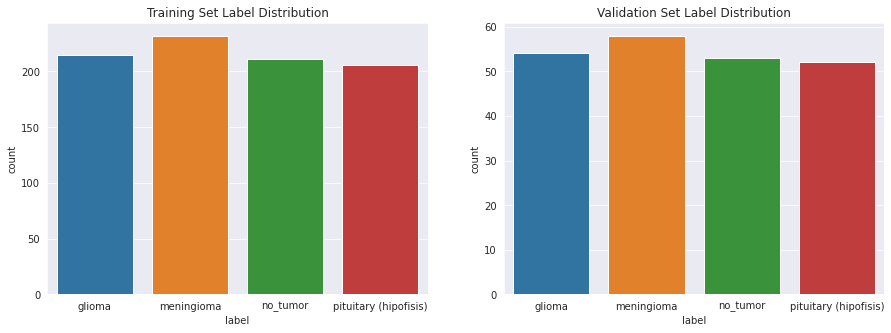

In [14]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 2, figsize = [15, 5])
sns.countplot(train_set[['label']].sort_values(by = 'label', ascending = True)['label'], ax = ax[0])
sns.countplot(val_set[['label']].sort_values(by = 'label', ascending = True)['label'], ax = ax[1])
ax[0].set_xticklabels(['glioma', 'meningioma', 'no_tumor', 'pituitary (hipofisis)'])
ax[1].set_xticklabels(['glioma', 'meningioma', 'no_tumor', 'pituitary (hipofisis)'])
ax[0].set_title('Training Set Label Distribution')
ax[1].set_title('Validation Set Label Distribution')

### showing sample images

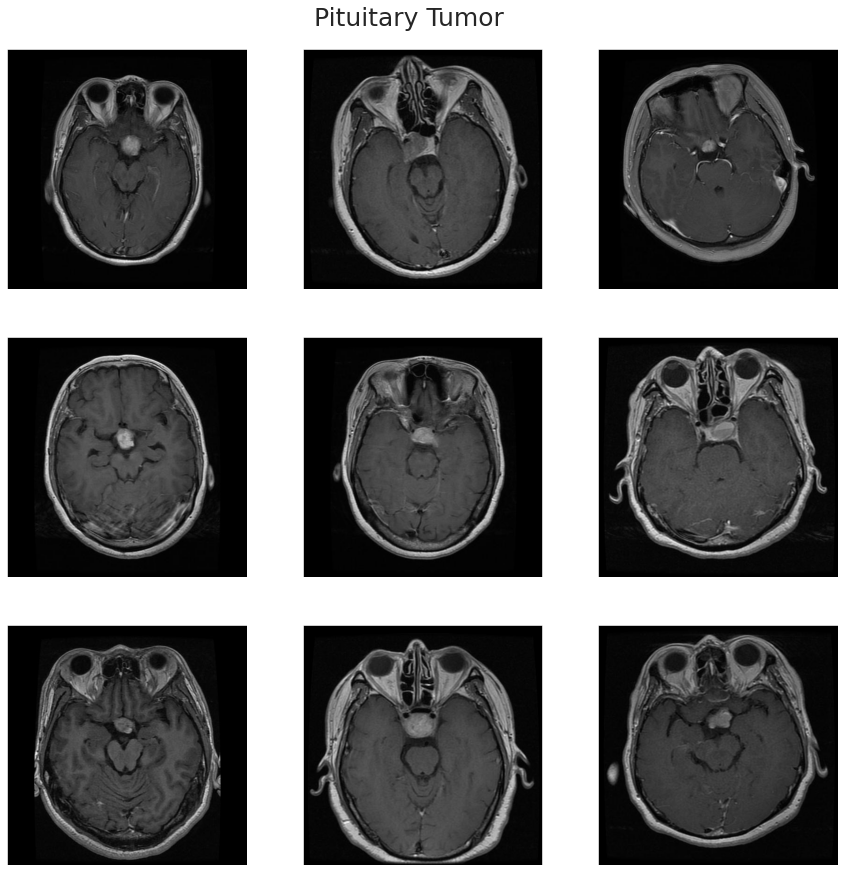

In [15]:
r = 3
c = 3
i = 1
plt.figure(figsize = [15, 15])
plt.suptitle('Pituitary Tumor', y = .92, size = 25)
for path in train_set[train_set['label'] == 'pituitary_tumor_fix'].sample(9, random_state = 2)['path'] :
    plt.subplot(r,c,i)
    img = load_img(path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1

In [16]:
train_notumor_path = glob.glob('./TRAIN/NO_TUMOR_FIX/*.*')
train_meningioma_path = glob.glob('./TRAIN/MENINGIOMA_TUMOR_FIX/*.*')
train_glioma_path = glob.glob('./TRAIN/GLIOMA_TUMOR_FIX/*.*')
train_pituitary_path = glob.glob('./TRAIN/PITUITARY_TUMOR_FIX/*.*')

In [17]:
val_notumor_path = glob.glob('./VAL/NO_TUMOR_FIX/*.*')
val_meningioma_path = glob.glob('./VAL/MENINGIOMA_TUMOR_FIX/*.*')
val_glioma_path = glob.glob('./VAL/GLIOMA_TUMOR_FIX/*.*')
val_pituitary_path = glob.glob('./VAL/PITUITARY_TUMOR_FIX/*.*')

sorting the path just like train_set and val_set

In [18]:
train_notumor_path2 = list(train_set[train_set['label'] == 'no_tumor_fix']['path'])
train_meningioma_path2 = list(train_set[train_set['label'] == 'meningioma_tumor_fix']['path'])
train_glioma_path2 = list(train_set[train_set['label'] == 'glioma_tumor_fix']['path'])
train_pituitary_path2 = list(train_set[train_set['label'] == 'pituitary_tumor_fix']['path'])

In [19]:
val_notumor_path2 = list(val_set[val_set['label'] == 'no_tumor_fix']['path'])
val_meningioma_path2 = list(val_set[val_set['label'] == 'meningioma_tumor_fix']['path'])
val_glioma_path2 = list(val_set[val_set['label'] == 'glioma_tumor_fix']['path'])
val_pituitary_path2 = list(val_set[val_set['label'] == 'pituitary_tumor_fix']['path'])

In [20]:
#train_glioma
np.random.seed(88)
random_index = list(np.random.randint(1, 100, 5))
random_index

[89, 33, 80, 50, 21]

In [21]:
def grayscale_plot(list_path, title) :
    n_img = len(list_path)
    fig = plt.figure(figsize = [15, (1*n_img)])
    i = 1
    plt.title(title, size = 20)
    plt.xticks([])
    plt.yticks([])
    sns.set_style('dark')
    for path in list_path :
        img = cv2.imread(path)
        ax = fig.add_subplot(2, n_img, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        plt.xticks([])
        plt.yticks([])
        #i += 1
        
        ax = fig.add_subplot(2, n_img, i+5)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        i += 1

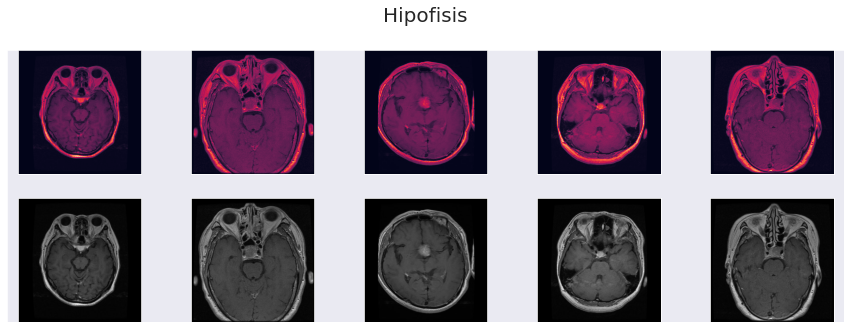

In [22]:
grayscale_plot(np.array(train_pituitary_path)[random_index], 'Hipofisis\n')

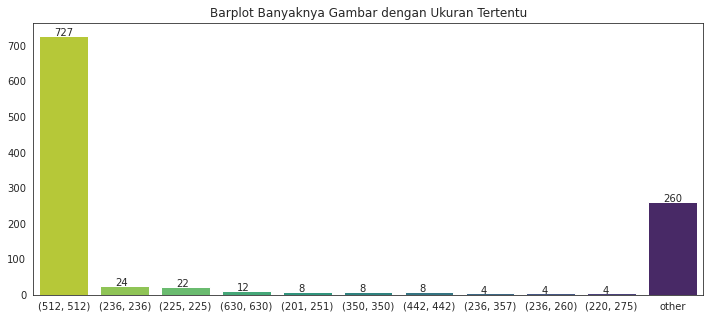

In [23]:
#list(train_df['size'].value_counts())
index = [str(i) for i in train_df['size'].value_counts()[:10].index]
index += ['other']
val = list(train_df['size'].value_counts()[:10])
val += [sum(train_df['size'].value_counts()[10:])]
sns.set_style('white')
plt.figure(figsize = [12, 5])
sns.barplot(y = val,
            x = index,
            palette = 'viridis_r')
plt.title('Barplot Banyaknya Gambar dengan Ukuran Tertentu')
for index, value in enumerate(val) :
    plt.text(index-.15, value, value)

### Syntax Resize

In [24]:
resize_img_path('./VAL', (224, 224))
resize_img_path('./TRAIN', (224, 224))

In [25]:
tumor_encode_dict = {'no_tumor' : 0,
                     'meningioma' : 1,
                     'glioma' : 2,
                     'pituitary' : 3}

In [26]:
def crop_plot(nocrop_path, crop_array, title) :
    n_img = len(nocrop_path)
    fig = plt.figure(figsize = [15, (1*n_img)])
    i = 1
    plt.title(title, size = 20)
    plt.xticks([])
    plt.yticks([])
    sns.set_style('dark')
    for nocrop, crop in zip(nocrop_path, crop_array) :
        img = cv2.imread(nocrop)        
        ax = fig.add_subplot(2, n_img, i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        #i += 1
        
        ax = fig.add_subplot(2, n_img, i+5)
        plt.imshow(crop)
        plt.xticks([])
        plt.yticks([])

        i += 1

In [27]:
crop_train_notumor = crop_imgs(train_notumor_path)
crop_train_meningioma = crop_imgs(train_meningioma_path)
crop_train_glioma = crop_imgs(train_glioma_path)
crop_train_pituitary = crop_imgs(train_pituitary_path)

In [28]:
#cv2.imread(train_notumor_path[0], cv2.CV_LOAD_IMAGE_GRAYSCALE)
#cv2.CV_LOAD_IMAGE_GRAYSCALE(train_notumor_path[0])

In [29]:
#train_notumor[0]
"""X_train = []
y_train = []
for notumor in train_notumor_path :
    image = tf.keras.preprocessing.image.load_img(notumor,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train.append(image)
    y_train.append(0)
    
for meningioma in train_meningioma_path :
    image = tf.keras.preprocessing.image.load_img(meningioma,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train.append(image)
    y_train.append(1)
    
for glioma in train_glioma_path :
    image = tf.keras.preprocessing.image.load_img(glioma,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train.append(image)
    y_train.append(2)
    
for pituitary in train_pituitary_path :
    image = tf.keras.preprocessing.image.load_img(pituitary,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train.append(image)
    y_train.append(3)
    
X_train = np.array(X_train)
y_train = np.array(y_train)"""

"X_train = []\ny_train = []\nfor notumor in train_notumor_path :\n    image = tf.keras.preprocessing.image.load_img(notumor,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n    X_train.append(image)\n    y_train.append(0)\n    \nfor meningioma in train_meningioma_path :\n    image = tf.keras.preprocessing.image.load_img(meningioma,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n    X_train.append(image)\n    y_train.append(1)\n    \nfor glioma in train_glioma_path :\n    image = tf.keras.preprocessing.image.load_img(glioma,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n    X_train.append(image)\n    y_train.append(2)\n    \nfor pituitary in train_pituitary_path :\n    image = tf.keras.preprocessing.image.load_img(pituitary,\n                                                  color_mode = 'grayscale')\n    imag

In [30]:
#train_notumor[0]
X_train = []
X_train_name = []
y_train = []
for notumor in train_notumor_path2 :
    dir_ = './TRAIN/NO_TUMOR_FIX/' + notumor.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train_name.append(dir_)
    X_train.append(image)
    y_train.append(0)
    
for meningioma in train_meningioma_path2 :
    dir_ = './TRAIN/MENINGIOMA_TUMOR_FIX/' + meningioma.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train_name.append(dir_)
    X_train.append(image)
    y_train.append(1)
    
for glioma in train_glioma_path2 :
    dir_ = './TRAIN/GLIOMA_TUMOR_FIX/' + glioma.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train_name.append(dir_)
    X_train.append(image)
    y_train.append(2)
    
for pituitary in train_pituitary_path2 :
    dir_ = './TRAIN/PITUITARY_TUMOR_FIX/' + pituitary.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_train_name.append(dir_)
    X_train.append(image)
    y_train.append(3)
    
X_train = np.array(X_train)
y_train = np.array(y_train)

In [31]:
crop_val_notumor = crop_imgs(val_notumor_path)
crop_val_meningioma = crop_imgs(val_meningioma_path)
crop_val_glioma = crop_imgs(val_glioma_path)
crop_val_pituitary = crop_imgs(val_pituitary_path)

In [32]:
#val_notumor[0]
"""X_val = []
y_val = []
for notumor in val_notumor_path :
    image = tf.keras.preprocessing.image.load_img(notumor,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val.append(image)
    y_val.append(0)
    
for meningioma in val_meningioma_path :
    image = tf.keras.preprocessing.image.load_img(meningioma,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val.append(image)
    y_val.append(1)
    
for glioma in val_glioma_path :
    image = tf.keras.preprocessing.image.load_img(glioma,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val.append(image)
    y_val.append(2)
    
for pituitary in val_pituitary_path :
    image = tf.keras.preprocessing.image.load_img(pituitary,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val.append(image)
    y_val.append(3)
    
X_val = np.array(X_val)
y_val = np.array(y_val)"""

"X_val = []\ny_val = []\nfor notumor in val_notumor_path :\n    image = tf.keras.preprocessing.image.load_img(notumor,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n    X_val.append(image)\n    y_val.append(0)\n    \nfor meningioma in val_meningioma_path :\n    image = tf.keras.preprocessing.image.load_img(meningioma,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n    X_val.append(image)\n    y_val.append(1)\n    \nfor glioma in val_glioma_path :\n    image = tf.keras.preprocessing.image.load_img(glioma,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n    X_val.append(image)\n    y_val.append(2)\n    \nfor pituitary in val_pituitary_path :\n    image = tf.keras.preprocessing.image.load_img(pituitary,\n                                                  color_mode = 'grayscale')\n    image = np.array(image)\n   

In [33]:
#val_notumor[0]
X_val = []
X_val_name = []
y_val = []
for notumor in val_notumor_path2 :
    dir_ = './VAL/NO_TUMOR_FIX/' + notumor.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val_name.append(dir_)
    X_val.append(image)
    y_val.append(0)
    
for meningioma in val_meningioma_path2 :
    dir_ = './VAL/MENINGIOMA_TUMOR_FIX/' + meningioma.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val_name.append(dir_)
    X_val.append(image)
    y_val.append(1)
    
for glioma in val_glioma_path2 :
    dir_ = './VAL/GLIOMA_TUMOR_FIX/' + glioma.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val_name.append(dir_)
    X_val.append(image)
    y_val.append(2)
    
for pituitary in val_pituitary_path2 :
    dir_ = './VAL/PITUITARY_TUMOR_FIX/' + pituitary.split('_fix/', 1)[1]
    image = tf.keras.preprocessing.image.load_img(dir_,
                                                  color_mode = 'grayscale')
    image = np.array(image)
    X_val_name.append(dir_)
    X_val.append(image)
    y_val.append(3)
    
X_val = np.array(X_val)
y_val = np.array(y_val)

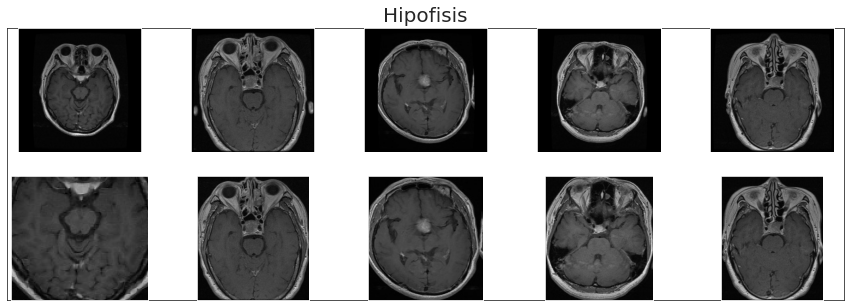

In [34]:
var = train_pituitary_path
crop_var = crop_train_pituitary
crop_plot(np.array(var)[random_index], crop_var[random_index], 'Hipofisis')

In [35]:
#cv2.IMREAD_GRAYSCALE(train_notumor_path[0])


In [36]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train,
                                                      y_train,
                                                      train_size = .8,
                                                      random_state = 1)

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train,
                                                      y_train,
                                                      train_size = .8,
                                                      random_state = 2)

X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train,
                                                      y_train,
                                                      train_size = .8,
                                                      random_state = 3)

X_train4, X_val4, y_train4, y_val4 = train_test_split(X_train,
                                                      y_train,
                                                      train_size = .8,
                                                      random_state = 4)

X_train5, X_val5, y_train5, y_val5 = train_test_split(X_train,
                                                      y_train,
                                                      train_size = .8,
                                                      random_state = 5)

In [37]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # start of stem mechanism
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    # end of stem mechanism
    
    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=256, activation='linear',kernel_regularizer=regularizers.l2(0.001))(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [38]:
CLASS_NUM = 4
BATCH_SIZE = 8
EPOCH_STEPS = int(X_train.shape[0]/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 1)
MODEL_NAME = 'skripsi_googlenet'

In [39]:
# train model
model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

optimizer = Adam(lr = 0.001, 
                 beta_1 = 0.9, 
                 beta_2 = 0.999, 
                 epsilon = 1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    steps_per_epoch = EPOCH_STEPS,
                    validation_data = (X_val,y_val))

model.save(MODEL_NAME)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
_______________________________________________________________________________________

Epoch 1/50
108/108 [==============================] - 5s 46ms/step - loss: 4.4478 - main_loss: 1.4512 - aux1_loss: 1.2763 - aux2_loss: 1.3607 - main_accuracy: 0.2882 - aux1_accuracy: 0.4340 - aux2_accuracy: 0.3380 - val_loss: 6.8466 - val_main_loss: 1.5290 - val_aux1_loss: 3.1275 - val_aux2_loss: 1.9020 - val_main_accuracy: 0.2442 - val_aux1_accuracy: 0.2442 - val_aux2_accuracy: 0.2442
Epoch 2/50
108/108 [==============================] - 4s 34ms/step - loss: 3.5640 - main_loss: 1.2455 - aux1_loss: 0.9720 - aux2_loss: 1.0920 - main_accuracy: 0.3993 - aux1_accuracy: 0.6019 - aux2_accuracy: 0.5301 - val_loss: 4.1656 - val_main_loss: 1.4368 - val_aux1_loss: 1.2336 - val_aux2_loss: 1.2695 - val_main_accuracy: 0.3733 - val_aux1_accuracy: 0.3456 - val_aux2_accuracy: 0.3410
Epoch 3/50
108/108 [==============================] - 4s 34ms/step - loss: 3.1446 - main_loss: 1.2170 - aux1_loss: 0.8106 - aux2_loss: 0.9111 - main_accuracy: 0.4259 - aux1_accuracy: 0.6725 - aux2_accuracy: 0.6204 - val_lo

108/108 [==============================] - 4s 35ms/step - loss: 0.4800 - main_loss: 0.1561 - aux1_loss: 0.1232 - aux2_loss: 0.1251 - main_accuracy: 0.9502 - aux1_accuracy: 0.9560 - aux2_accuracy: 0.9606 - val_loss: 1.0900 - val_main_loss: 0.3333 - val_aux1_loss: 0.3471 - val_aux2_loss: 0.3344 - val_main_accuracy: 0.9078 - val_aux1_accuracy: 0.8848 - val_aux2_accuracy: 0.8894
Epoch 23/50
108/108 [==============================] - 4s 35ms/step - loss: 0.5661 - main_loss: 0.2310 - aux1_loss: 0.1248 - aux2_loss: 0.1362 - main_accuracy: 0.9294 - aux1_accuracy: 0.9514 - aux2_accuracy: 0.9560 - val_loss: 0.9185 - val_main_loss: 0.3318 - val_aux1_loss: 0.2413 - val_aux2_loss: 0.2720 - val_main_accuracy: 0.8756 - val_aux1_accuracy: 0.9078 - val_aux2_accuracy: 0.8986
Epoch 24/50
108/108 [==============================] - 4s 34ms/step - loss: 0.4863 - main_loss: 0.1726 - aux1_loss: 0.1078 - aux2_loss: 0.1322 - main_accuracy: 0.9468 - aux1_accuracy: 0.9583 - aux2_accuracy: 0.9595 - val_loss: 0.910

108/108 [==============================] - 4s 34ms/step - loss: 0.1884 - main_loss: 0.0584 - aux1_loss: 0.0271 - aux2_loss: 0.0382 - main_accuracy: 0.9826 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9873 - val_loss: 0.9711 - val_main_loss: 0.2872 - val_aux1_loss: 0.3003 - val_aux2_loss: 0.3190 - val_main_accuracy: 0.9309 - val_aux1_accuracy: 0.9263 - val_aux2_accuracy: 0.9217
Epoch 44/50
108/108 [==============================] - 4s 34ms/step - loss: 0.1262 - main_loss: 0.0272 - aux1_loss: 0.0045 - aux2_loss: 0.0317 - main_accuracy: 0.9954 - aux1_accuracy: 1.0000 - aux2_accuracy: 0.9919 - val_loss: 1.3808 - val_main_loss: 0.3911 - val_aux1_loss: 0.3071 - val_aux2_loss: 0.6210 - val_main_accuracy: 0.9032 - val_aux1_accuracy: 0.9447 - val_aux2_accuracy: 0.8940
Epoch 45/50
108/108 [==============================] - 4s 34ms/step - loss: 0.1025 - main_loss: 0.0210 - aux1_loss: 0.0123 - aux2_loss: 0.0090 - main_accuracy: 0.9954 - aux1_accuracy: 0.9954 - aux2_accuracy: 0.9988 - val_loss: 1.724

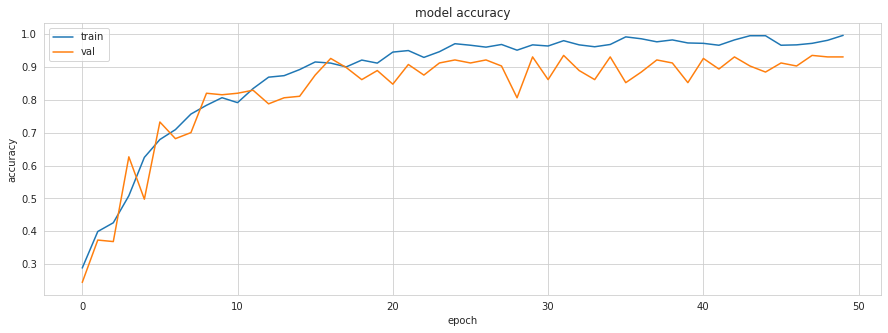

In [40]:
plt.figure(figsize = [15, 5])
sns.set_style('whitegrid')
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

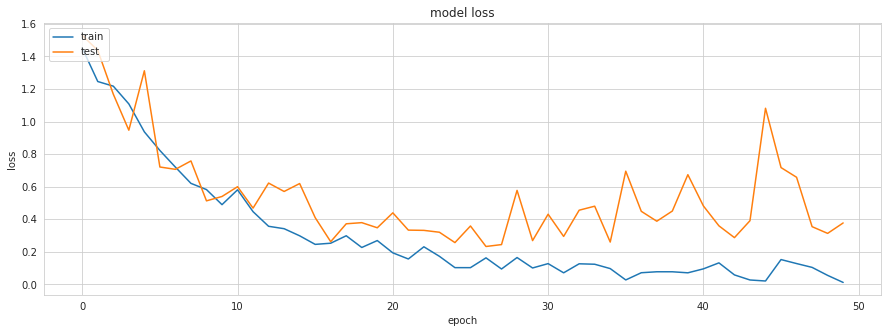

In [41]:
plt.figure(figsize = [15, 5])
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
score = model.evaluate(X_val, y_val)
print('Score:', score[4])#akurasi

print('\n loss')
print('Score:', score[1])

7/7 [==============================] - 0s 23ms/step - loss: 1.0836 - main_loss: 0.3773 - aux1_loss: 0.3004 - aux2_loss: 0.3441 - main_accuracy: 0.9309 - aux1_accuracy: 0.9539 - aux2_accuracy: 0.9355
Score: 0.9308755993843079

 loss
Score: 0.37731802463531494


In [43]:
res = prob_converter(model.predict(X_val))
res_average = prob_average(model.predict(X_val))
print(confusion_matrix(np.array(res), np.array(y_val)))
print(accuracy_score(np.array(res), np.array(y_val)))

[[52  3  0  0]
 [ 1 51  0  5]
 [ 0  3 54  0]
 [ 0  1  0 47]]
0.9400921658986175


In [44]:
# train model
CLASS_NUM = 4
BATCH_SIZE = 8
EPOCH_STEPS = int(X_train1.shape[0]/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 1)
MODEL_NAME = 'skripsi_googlenet'


model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

optimizer = Adam(lr = 0.001, 
                 beta_1 = 0.9, 
                 beta_2 = 0.999, 
                 epsilon = 1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

history = model.fit(X_train1,
                    y_train1,
                    epochs = 50,
                    steps_per_epoch = EPOCH_STEPS,
                    validation_data = (X_val1,y_val1))

model.save(MODEL_NAME)

res = prob_converter(model.predict(X_val1))
res_average = prob_average(model.predict(X_val1))
print(confusion_matrix(np.array(res), np.array(y_val1)))
print(accuracy_score(np.array(res), np.array(y_val1)))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 112, 112, 64) 3200        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_13[0][0]           
_______________________________________________________________________________________

Epoch 1/50
86/86 [==============================] - 5s 55ms/step - loss: 4.6092 - main_loss: 1.4559 - aux1_loss: 1.4479 - aux2_loss: 1.3232 - main_accuracy: 0.3355 - aux1_accuracy: 0.4028 - aux2_accuracy: 0.3718 - val_loss: 6.4940 - val_main_loss: 1.9574 - val_aux1_loss: 2.2787 - val_aux2_loss: 1.9375 - val_main_accuracy: 0.2428 - val_aux1_accuracy: 0.2717 - val_aux2_accuracy: 0.2428
Epoch 2/50
86/86 [==============================] - 3s 36ms/step - loss: 3.7142 - main_loss: 1.2199 - aux1_loss: 1.0585 - aux2_loss: 1.1451 - main_accuracy: 0.4249 - aux1_accuracy: 0.5712 - aux2_accuracy: 0.4845 - val_loss: 5.1342 - val_main_loss: 1.6782 - val_aux1_loss: 1.7493 - val_aux2_loss: 1.4423 - val_main_accuracy: 0.2659 - val_aux1_accuracy: 0.2601 - val_aux2_accuracy: 0.2775
Epoch 3/50
86/86 [==============================] - 3s 35ms/step - loss: 3.2568 - main_loss: 1.1632 - aux1_loss: 0.8834 - aux2_loss: 0.9651 - main_accuracy: 0.4806 - aux1_accuracy: 0.6282 - aux2_accuracy: 0.5984 - val_loss: 3.

86/86 [==============================] - 3s 36ms/step - loss: 0.5031 - main_loss: 0.1930 - aux1_loss: 0.1050 - aux2_loss: 0.1240 - main_accuracy: 0.9417 - aux1_accuracy: 0.9715 - aux2_accuracy: 0.9495 - val_loss: 1.7093 - val_main_loss: 0.4668 - val_aux1_loss: 0.5871 - val_aux2_loss: 0.5755 - val_main_accuracy: 0.8671 - val_aux1_accuracy: 0.8786 - val_aux2_accuracy: 0.8728
Epoch 23/50
86/86 [==============================] - 3s 36ms/step - loss: 0.4265 - main_loss: 0.1332 - aux1_loss: 0.1129 - aux2_loss: 0.1016 - main_accuracy: 0.9611 - aux1_accuracy: 0.9637 - aux2_accuracy: 0.9598 - val_loss: 1.6694 - val_main_loss: 0.6165 - val_aux1_loss: 0.4199 - val_aux2_loss: 0.5552 - val_main_accuracy: 0.8671 - val_aux1_accuracy: 0.8960 - val_aux2_accuracy: 0.8671
Epoch 24/50
86/86 [==============================] - 3s 36ms/step - loss: 0.3463 - main_loss: 0.1133 - aux1_loss: 0.0874 - aux2_loss: 0.0689 - main_accuracy: 0.9573 - aux1_accuracy: 0.9663 - aux2_accuracy: 0.9754 - val_loss: 0.9685 - va

86/86 [==============================] - 3s 36ms/step - loss: 0.0561 - main_loss: 4.4822e-04 - aux1_loss: 8.6433e-04 - aux2_loss: 2.5802e-04 - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 1.0000 - val_loss: 1.4218 - val_main_loss: 0.4902 - val_aux1_loss: 0.4345 - val_aux2_loss: 0.4441 - val_main_accuracy: 0.9480 - val_aux1_accuracy: 0.9422 - val_aux2_accuracy: 0.9422
Epoch 44/50
86/86 [==============================] - 3s 36ms/step - loss: 0.0552 - main_loss: 7.8089e-04 - aux1_loss: 0.0026 - aux2_loss: 2.1638e-04 - main_accuracy: 1.0000 - aux1_accuracy: 0.9987 - aux2_accuracy: 1.0000 - val_loss: 1.4160 - val_main_loss: 0.4362 - val_aux1_loss: 0.4625 - val_aux2_loss: 0.4669 - val_main_accuracy: 0.9480 - val_aux1_accuracy: 0.9422 - val_aux2_accuracy: 0.9422
Epoch 45/50
66/86 [======================>.......] - 2s 37ms/step - loss: 0.0507 - main_loss: 3.4896e-04 - aux1_loss: 7.0676e-04 - aux2_loss: 2.1806e-04 - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy

In [45]:
# train model
CLASS_NUM = 4
BATCH_SIZE = 8
EPOCH_STEPS = int(X_train2.shape[0]/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 1)
MODEL_NAME = 'skripsi_googlenet'


model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

optimizer = Adam(lr = 0.001, 
                 beta_1 = 0.9, 
                 beta_2 = 0.999, 
                 epsilon = 1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

history = model.fit(X_train2,
                    y_train2,
                    epochs = 50,
                    steps_per_epoch = EPOCH_STEPS,
                    validation_data = (X_val2,y_val2))

model.save(MODEL_NAME)

res2 = prob_converter(model.predict(X_val2))
res_average2 = prob_average(model.predict(X_val2))
print(confusion_matrix(np.array(res2), np.array(y_val2)))
print(accuracy_score(np.array(res2), np.array(y_val2)))

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 112, 112, 64) 3200        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_118[0][0]                 
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_26[0][0]           
_______________________________________________________________________________________

Epoch 1/50
86/86 [==============================] - 4s 46ms/step - loss: 4.3398 - main_loss: 1.4035 - aux1_loss: 1.2527 - aux2_loss: 1.3210 - main_accuracy: 0.3264 - aux1_accuracy: 0.4819 - aux2_accuracy: 0.3497 - val_loss: 4.0559 - val_main_loss: 1.4184 - val_aux1_loss: 1.1083 - val_aux2_loss: 1.2350 - val_main_accuracy: 0.2486 - val_aux1_accuracy: 0.4451 - val_aux2_accuracy: 0.4046
Epoch 2/50
86/86 [==============================] - 3s 36ms/step - loss: 3.5027 - main_loss: 1.2544 - aux1_loss: 0.8982 - aux2_loss: 1.0836 - main_accuracy: 0.3795 - aux1_accuracy: 0.6256 - aux2_accuracy: 0.5272 - val_loss: 4.3549 - val_main_loss: 1.3613 - val_aux1_loss: 1.1060 - val_aux2_loss: 1.6434 - val_main_accuracy: 0.2775 - val_aux1_accuracy: 0.4393 - val_aux2_accuracy: 0.3699
Epoch 3/50
86/86 [==============================] - 3s 36ms/step - loss: 3.2595 - main_loss: 1.2302 - aux1_loss: 0.8198 - aux2_loss: 0.9811 - main_accuracy: 0.4624 - aux1_accuracy: 0.6645 - aux2_accuracy: 0.6062 - val_loss: 2.

86/86 [==============================] - 3s 39ms/step - loss: 0.4491 - main_loss: 0.1384 - aux1_loss: 0.0995 - aux2_loss: 0.1270 - main_accuracy: 0.9573 - aux1_accuracy: 0.9702 - aux2_accuracy: 0.9495 - val_loss: 1.1343 - val_main_loss: 0.4059 - val_aux1_loss: 0.2995 - val_aux2_loss: 0.3456 - val_main_accuracy: 0.9133 - val_aux1_accuracy: 0.9306 - val_aux2_accuracy: 0.9422
Epoch 23/50
86/86 [==============================] - 3s 36ms/step - loss: 0.6091 - main_loss: 0.2203 - aux1_loss: 0.1447 - aux2_loss: 0.1622 - main_accuracy: 0.9365 - aux1_accuracy: 0.9573 - aux2_accuracy: 0.9482 - val_loss: 1.0495 - val_main_loss: 0.3734 - val_aux1_loss: 0.3086 - val_aux2_loss: 0.2869 - val_main_accuracy: 0.8555 - val_aux1_accuracy: 0.9306 - val_aux2_accuracy: 0.9422
Epoch 24/50
86/86 [==============================] - 3s 35ms/step - loss: 0.4378 - main_loss: 0.1442 - aux1_loss: 0.1072 - aux2_loss: 0.1059 - main_accuracy: 0.9443 - aux1_accuracy: 0.9637 - aux2_accuracy: 0.9650 - val_loss: 1.4301 - va

86/86 [==============================] - 3s 36ms/step - loss: 0.3699 - main_loss: 0.1278 - aux1_loss: 0.0959 - aux2_loss: 0.0728 - main_accuracy: 0.9688 - aux1_accuracy: 0.9649 - aux2_accuracy: 0.9740 - val_loss: 1.4448 - val_main_loss: 0.4671 - val_aux1_loss: 0.4482 - val_aux2_loss: 0.4572 - val_main_accuracy: 0.9191 - val_aux1_accuracy: 0.9191 - val_aux2_accuracy: 0.9075
Epoch 44/50
86/86 [==============================] - 3s 36ms/step - loss: 0.2989 - main_loss: 0.0810 - aux1_loss: 0.0851 - aux2_loss: 0.0611 - main_accuracy: 0.9728 - aux1_accuracy: 0.9689 - aux2_accuracy: 0.9819 - val_loss: 1.0524 - val_main_loss: 0.4413 - val_aux1_loss: 0.2701 - val_aux2_loss: 0.2705 - val_main_accuracy: 0.9017 - val_aux1_accuracy: 0.9364 - val_aux2_accuracy: 0.9422
Epoch 45/50
66/86 [======================>.......] - 2s 37ms/step - loss: 0.2568 - main_loss: 0.1085 - aux1_loss: 0.0293 - aux2_loss: 0.0497 - main_accuracy: 0.9780 - aux1_accuracy: 0.9882 - aux2_accuracy: 0.9831 - val_loss: 1.2232 - va

In [46]:
# train model
CLASS_NUM = 4
BATCH_SIZE = 8
EPOCH_STEPS = int(X_train3.shape[0]/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 1)
MODEL_NAME = 'skripsi_googlenet'



model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

optimizer = Adam(lr = 0.001, 
                 beta_1 = 0.9, 
                 beta_2 = 0.999, 
                 epsilon = 1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

history = model.fit(X_train3,
                    y_train3,
                    epochs = 50,
                    steps_per_epoch = EPOCH_STEPS,
                    validation_data = (X_val3,y_val3))

model.save(MODEL_NAME)

res3 = prob_converter(model.predict(X_val3))
res_average3 = prob_average(model.predict(X_val3))
print(confusion_matrix(np.array(res3), np.array(y_val3)))
print(accuracy_score(np.array(res3), np.array(y_val3)))

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 112, 112, 64) 3200        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_177[0][0]                 
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_39[0][0]           
_______________________________________________________________________________________

Epoch 1/50
86/86 [==============================] - 4s 45ms/step - loss: 4.7208 - main_loss: 1.5297 - aux1_loss: 1.4230 - aux2_loss: 1.3971 - main_accuracy: 0.2850 - aux1_accuracy: 0.4223 - aux2_accuracy: 0.3031 - val_loss: 5.5230 - val_main_loss: 1.4021 - val_aux1_loss: 2.1959 - val_aux2_loss: 1.6204 - val_main_accuracy: 0.2370 - val_aux1_accuracy: 0.2948 - val_aux2_accuracy: 0.2948
Epoch 2/50
86/86 [==============================] - 3s 36ms/step - loss: 3.6183 - main_loss: 1.2881 - aux1_loss: 0.9545 - aux2_loss: 1.0999 - main_accuracy: 0.3938 - aux1_accuracy: 0.5855 - aux2_accuracy: 0.5155 - val_loss: 3.4652 - val_main_loss: 1.2276 - val_aux1_loss: 0.9457 - val_aux2_loss: 1.0402 - val_main_accuracy: 0.4220 - val_aux1_accuracy: 0.6127 - val_aux2_accuracy: 0.7168
Epoch 3/50
86/86 [==============================] - 3s 36ms/step - loss: 3.2573 - main_loss: 1.2119 - aux1_loss: 0.8719 - aux2_loss: 0.9399 - main_accuracy: 0.4469 - aux1_accuracy: 0.6373 - aux2_accuracy: 0.6127 - val_loss: 4.

86/86 [==============================] - 3s 37ms/step - loss: 0.7126 - main_loss: 0.2494 - aux1_loss: 0.1712 - aux2_loss: 0.2163 - main_accuracy: 0.9119 - aux1_accuracy: 0.9430 - aux2_accuracy: 0.9301 - val_loss: 1.2160 - val_main_loss: 0.4584 - val_aux1_loss: 0.3444 - val_aux2_loss: 0.3373 - val_main_accuracy: 0.8902 - val_aux1_accuracy: 0.9191 - val_aux2_accuracy: 0.8960
Epoch 23/50
86/86 [==============================] - 3s 36ms/step - loss: 0.8762 - main_loss: 0.2988 - aux1_loss: 0.2490 - aux2_loss: 0.2534 - main_accuracy: 0.8964 - aux1_accuracy: 0.9171 - aux2_accuracy: 0.9132 - val_loss: 1.0538 - val_main_loss: 0.2871 - val_aux1_loss: 0.3731 - val_aux2_loss: 0.3195 - val_main_accuracy: 0.8960 - val_aux1_accuracy: 0.9017 - val_aux2_accuracy: 0.8960
Epoch 24/50
86/86 [==============================] - 3s 36ms/step - loss: 0.6959 - main_loss: 0.2264 - aux1_loss: 0.1795 - aux2_loss: 0.2156 - main_accuracy: 0.9145 - aux1_accuracy: 0.9326 - aux2_accuracy: 0.9210 - val_loss: 1.4460 - va

86/86 [==============================] - 3s 37ms/step - loss: 0.2343 - main_loss: 0.0699 - aux1_loss: 0.0543 - aux2_loss: 0.0481 - main_accuracy: 0.9753 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9883 - val_loss: 2.2074 - val_main_loss: 0.7308 - val_aux1_loss: 0.7318 - val_aux2_loss: 0.6837 - val_main_accuracy: 0.8208 - val_aux1_accuracy: 0.8382 - val_aux2_accuracy: 0.8671
Epoch 44/50
86/86 [==============================] - 3s 36ms/step - loss: 0.6457 - main_loss: 0.2939 - aux1_loss: 0.1358 - aux2_loss: 0.1553 - main_accuracy: 0.9352 - aux1_accuracy: 0.9624 - aux2_accuracy: 0.9521 - val_loss: 1.3016 - val_main_loss: 0.5013 - val_aux1_loss: 0.3479 - val_aux2_loss: 0.3892 - val_main_accuracy: 0.8613 - val_aux1_accuracy: 0.9133 - val_aux2_accuracy: 0.9075
Epoch 45/50
66/86 [======================>.......] - 2s 37ms/step - loss: 0.4090 - main_loss: 0.1539 - aux1_loss: 0.0925 - aux2_loss: 0.0967 - main_accuracy: 0.9578 - aux1_accuracy: 0.9730 - aux2_accuracy: 0.9679 - val_loss: 1.3258 - va

In [47]:
# train model
CLASS_NUM = 4
BATCH_SIZE = 8
EPOCH_STEPS = int(X_train4.shape[0]/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 1)
MODEL_NAME = 'skripsi_googlenet'


model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

optimizer = Adam(lr = 0.001, 
                 beta_1 = 0.9, 
                 beta_2 = 0.999, 
                 epsilon = 1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

history = model.fit(X_train4,
                    y_train4,
                    epochs = 50,
                    steps_per_epoch = EPOCH_STEPS,
                    validation_data = (X_val4,y_val4))

model.save(MODEL_NAME)

res4 = prob_converter(model.predict(X_val4))
res_average4 = prob_average(model.predict(X_val4))
print(confusion_matrix(np.array(res4), np.array(y_val4)))
print(accuracy_score(np.array(res4), np.array(y_val4)))

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_236 (Conv2D)             (None, 112, 112, 64) 3200        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_236[0][0]                 
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_52[0][0]           
_______________________________________________________________________________________

Epoch 1/50
86/86 [==============================] - 4s 46ms/step - loss: 4.5411 - main_loss: 1.4388 - aux1_loss: 1.3318 - aux2_loss: 1.3934 - main_accuracy: 0.2876 - aux1_accuracy: 0.4301 - aux2_accuracy: 0.3394 - val_loss: 4.8303 - val_main_loss: 1.3847 - val_aux1_loss: 1.6753 - val_aux2_loss: 1.4592 - val_main_accuracy: 0.3121 - val_aux1_accuracy: 0.2543 - val_aux2_accuracy: 0.3121
Epoch 2/50
86/86 [==============================] - 3s 37ms/step - loss: 3.5814 - main_loss: 1.2444 - aux1_loss: 0.9292 - aux2_loss: 1.1261 - main_accuracy: 0.4158 - aux1_accuracy: 0.6088 - aux2_accuracy: 0.5350 - val_loss: 7.3364 - val_main_loss: 2.6826 - val_aux1_loss: 2.4352 - val_aux2_loss: 1.9623 - val_main_accuracy: 0.2543 - val_aux1_accuracy: 0.2543 - val_aux2_accuracy: 0.2543
Epoch 3/50
86/86 [==============================] - 3s 36ms/step - loss: 3.2335 - main_loss: 1.2192 - aux1_loss: 0.7930 - aux2_loss: 0.9843 - main_accuracy: 0.4210 - aux1_accuracy: 0.6852 - aux2_accuracy: 0.6153 - val_loss: 4.

86/86 [==============================] - 3s 37ms/step - loss: 0.8166 - main_loss: 0.2764 - aux1_loss: 0.2239 - aux2_loss: 0.2325 - main_accuracy: 0.9080 - aux1_accuracy: 0.9106 - aux2_accuracy: 0.9028 - val_loss: 3.1137 - val_main_loss: 2.0085 - val_aux1_loss: 0.4894 - val_aux2_loss: 0.5313 - val_main_accuracy: 0.7283 - val_aux1_accuracy: 0.8382 - val_aux2_accuracy: 0.8035
Epoch 23/50
86/86 [==============================] - 3s 36ms/step - loss: 0.9189 - main_loss: 0.3914 - aux1_loss: 0.2099 - aux2_loss: 0.2344 - main_accuracy: 0.8821 - aux1_accuracy: 0.9067 - aux2_accuracy: 0.9080 - val_loss: 2.0843 - val_main_loss: 0.6951 - val_aux1_loss: 0.6181 - val_aux2_loss: 0.6887 - val_main_accuracy: 0.7803 - val_aux1_accuracy: 0.8208 - val_aux2_accuracy: 0.7977
Epoch 24/50
86/86 [==============================] - 3s 36ms/step - loss: 0.8220 - main_loss: 0.2950 - aux1_loss: 0.2057 - aux2_loss: 0.2394 - main_accuracy: 0.8834 - aux1_accuracy: 0.9339 - aux2_accuracy: 0.9106 - val_loss: 1.5630 - va

86/86 [==============================] - 3s 37ms/step - loss: 0.1087 - main_loss: 0.0235 - aux1_loss: 0.0090 - aux2_loss: 0.0080 - main_accuracy: 0.9909 - aux1_accuracy: 0.9974 - aux2_accuracy: 0.9987 - val_loss: 1.9230 - val_main_loss: 0.5655 - val_aux1_loss: 0.6614 - val_aux2_loss: 0.6297 - val_main_accuracy: 0.8960 - val_aux1_accuracy: 0.9133 - val_aux2_accuracy: 0.9075
Epoch 44/50
86/86 [==============================] - 3s 36ms/step - loss: 0.1034 - main_loss: 0.0149 - aux1_loss: 0.0199 - aux2_loss: 0.0036 - main_accuracy: 0.9948 - aux1_accuracy: 0.9961 - aux2_accuracy: 1.0000 - val_loss: 1.8157 - val_main_loss: 0.5772 - val_aux1_loss: 0.5884 - val_aux2_loss: 0.5859 - val_main_accuracy: 0.8960 - val_aux1_accuracy: 0.9017 - val_aux2_accuracy: 0.9191
Epoch 45/50
66/86 [======================>.......] - 2s 36ms/step - loss: 0.1361 - main_loss: 0.0263 - aux1_loss: 0.0290 - aux2_loss: 0.0174 - main_accuracy: 0.9916 - aux1_accuracy: 0.9882 - aux2_accuracy: 0.9916 - val_loss: 2.5436 - va

In [48]:
# train model
CLASS_NUM = 4
BATCH_SIZE = 8
EPOCH_STEPS = int(X_train5.shape[0]/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 1)
MODEL_NAME = 'skripsi_googlenet'



model = googlenet()
model.summary()
#model.load_weights(MODEL_NAME)
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

optimizer = Adam(lr = 0.001, 
                 beta_1 = 0.9, 
                 beta_2 = 0.999, 
                 epsilon = 1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

history = model.fit(X_train5,
                    y_train5,
                    epochs = 50,
                    steps_per_epoch = EPOCH_STEPS,
                    validation_data = (X_val5,y_val5))

model.save(MODEL_NAME)

res5 = prob_converter(model.predict(X_val5))
res_average5 = prob_average(model.predict(X_val5))
print(confusion_matrix(np.array(res5), np.array(y_val5)))
print(accuracy_score(np.array(res5), np.array(y_val5)))

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_295 (Conv2D)             (None, 112, 112, 64) 3200        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_295[0][0]                 
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 56, 56, 64)   256         max_pooling2d_65[0][0]           
______________________________________________________________________________________

Epoch 1/50
86/86 [==============================] - 4s 45ms/step - loss: 4.3660 - main_loss: 1.3866 - aux1_loss: 1.3063 - aux2_loss: 1.3002 - main_accuracy: 0.3459 - aux1_accuracy: 0.4197 - aux2_accuracy: 0.3795 - val_loss: 8.0373 - val_main_loss: 2.3757 - val_aux1_loss: 2.9842 - val_aux2_loss: 2.3730 - val_main_accuracy: 0.1965 - val_aux1_accuracy: 0.1965 - val_aux2_accuracy: 0.1965
Epoch 2/50
86/86 [==============================] - 3s 36ms/step - loss: 3.5151 - main_loss: 1.2277 - aux1_loss: 0.9553 - aux2_loss: 1.0611 - main_accuracy: 0.4352 - aux1_accuracy: 0.6049 - aux2_accuracy: 0.5609 - val_loss: 4.1311 - val_main_loss: 1.2779 - val_aux1_loss: 1.3639 - val_aux2_loss: 1.2465 - val_main_accuracy: 0.3295 - val_aux1_accuracy: 0.3757 - val_aux2_accuracy: 0.3526
Epoch 3/50
86/86 [==============================] - 3s 36ms/step - loss: 3.2327 - main_loss: 1.2185 - aux1_loss: 0.8190 - aux2_loss: 0.9717 - main_accuracy: 0.4598 - aux1_accuracy: 0.6697 - aux2_accuracy: 0.5959 - val_loss: 3.

86/86 [==============================] - 3s 37ms/step - loss: 0.3969 - main_loss: 0.1251 - aux1_loss: 0.0944 - aux2_loss: 0.1025 - main_accuracy: 0.9573 - aux1_accuracy: 0.9650 - aux2_accuracy: 0.9689 - val_loss: 5.5234 - val_main_loss: 2.0401 - val_aux1_loss: 1.6511 - val_aux2_loss: 1.7580 - val_main_accuracy: 0.6821 - val_aux1_accuracy: 0.7168 - val_aux2_accuracy: 0.6879
Epoch 23/50
86/86 [==============================] - 3s 36ms/step - loss: 0.5871 - main_loss: 0.2336 - aux1_loss: 0.1380 - aux2_loss: 0.1413 - main_accuracy: 0.9288 - aux1_accuracy: 0.9521 - aux2_accuracy: 0.9443 - val_loss: 1.4094 - val_main_loss: 0.5215 - val_aux1_loss: 0.3922 - val_aux2_loss: 0.4211 - val_main_accuracy: 0.8613 - val_aux1_accuracy: 0.8613 - val_aux2_accuracy: 0.8902
Epoch 24/50
86/86 [==============================] - 3s 36ms/step - loss: 0.3104 - main_loss: 0.1193 - aux1_loss: 0.0489 - aux2_loss: 0.0691 - main_accuracy: 0.9650 - aux1_accuracy: 0.9858 - aux2_accuracy: 0.9754 - val_loss: 2.3801 - va

86/86 [==============================] - 3s 37ms/step - loss: 0.2327 - main_loss: 0.0789 - aux1_loss: 0.0511 - aux2_loss: 0.0470 - main_accuracy: 0.9844 - aux1_accuracy: 0.9857 - aux2_accuracy: 0.9870 - val_loss: 1.0253 - val_main_loss: 0.2508 - val_aux1_loss: 0.4303 - val_aux2_loss: 0.2886 - val_main_accuracy: 0.9075 - val_aux1_accuracy: 0.9075 - val_aux2_accuracy: 0.9075
Epoch 44/50
86/86 [==============================] - 3s 36ms/step - loss: 0.1056 - main_loss: 0.0216 - aux1_loss: 0.0205 - aux2_loss: 0.0087 - main_accuracy: 0.9935 - aux1_accuracy: 0.9948 - aux2_accuracy: 0.9987 - val_loss: 0.9384 - val_main_loss: 0.2005 - val_aux1_loss: 0.4922 - val_aux2_loss: 0.1924 - val_main_accuracy: 0.9191 - val_aux1_accuracy: 0.9017 - val_aux2_accuracy: 0.9364
Epoch 45/50
66/86 [======================>.......] - 2s 37ms/step - loss: 0.0989 - main_loss: 0.0116 - aux1_loss: 0.0282 - aux2_loss: 0.0069 - main_accuracy: 0.9966 - aux1_accuracy: 0.9899 - aux2_accuracy: 0.9966 - val_loss: 1.8172 - va

In [49]:
#df_result = pd.DataFrame({'actual' : y_val,
                          #'pred' : res,
                          #'prob' : [list(i) for i in res_average]})
#df_result.to_csv('pred result 9 jan 2.csv', index = False)

In [50]:
def sample_plot(nrow, ncol, data, index) :
    fig = plt.figure(figsize = [3*ncol, 5*nrow])
    i = 1
    for index_ in index :
        ax = fig.add_subplot(nrow, ncol, i)
        plt.imshow(data[index_],
                   cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        plt.text(i-1, -2, index_, size = 30)
        i += 1

In [51]:
def image_to_vector_converter(data) : 
    dim = data[0].shape[0]
    result = []
    for img in tqdm(data) :
        res = []
        for i in list(range(dim)) :
            res += list(img[i])
        result.append(res)
    return pd.DataFrame(np.array(result))

In [52]:
X_train_df = image_to_vector_converter(X_train)
X_val_df = image_to_vector_converter(X_val)

In [53]:
X_train_df1 = image_to_vector_converter(X_train1)
X_val_df1 = image_to_vector_converter(X_val1)

X_train_df2 = image_to_vector_converter(X_train2)
X_val_df2 = image_to_vector_converter(X_val2)

X_train_df3 = image_to_vector_converter(X_train3)
X_val_df3 = image_to_vector_converter(X_val3)

X_train_df4 = image_to_vector_converter(X_train4)
X_val_df4 = image_to_vector_converter(X_val4)

X_train_df5 = image_to_vector_converter(X_train5)
X_val_df5 = image_to_vector_converter(X_val5)

In [54]:
classifiers = [LogisticRegression(),
               GaussianNB(),
               SVC(),
               RandomForestClassifier(random_state = 2),
               DecisionTreeClassifier(random_state = 2)]

acc_score = []
var_score = []
algos = []
for classifier in tqdm(classifiers) :
    algos.append(type(classifier).__name__)
    result = []
    
    # set 1
    classifier.fit(X_train_df1,
                   y_train1)
    pred = classifier.predict(X_val_df1)
    result.append(accuracy_score(np.array(pred), np.array(y_val1)))
    
    # set 2
    classifier.fit(X_train_df2,
                   y_train2)
    pred = classifier.predict(X_val_df2)
    result.append(accuracy_score(np.array(pred), np.array(y_val2)))
    
    # set 3
    classifier.fit(X_train_df3,
                   y_train3)
    pred = classifier.predict(X_val_df3)
    result.append(accuracy_score(np.array(pred), np.array(y_val3)))
    
    # set 4
    classifier.fit(X_train_df4,
                   y_train4)
    pred = classifier.predict(X_val_df4)
    result.append(accuracy_score(np.array(pred), np.array(y_val4)))
    
    # set 2
    classifier.fit(X_train_df5,
                   y_train5)
    pred = classifier.predict(X_val_df5)
    result.append(accuracy_score(np.array(pred), np.array(y_val5)))
    
    result = np.array(result)
    
    acc_score.append(result.mean())
    var_score.append(result.var())

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [55]:
pd.DataFrame({'method' : algos,
              'accuracy' : acc_score,
              'variance' : var_score})

algos.append('CNN & GoogLeNet')
acc_score.append(np.array([accuracy_score(np.array(res), np.array(y_val1)),
          accuracy_score(np.array(res2), np.array(y_val2)),
          accuracy_score(np.array(res3), np.array(y_val3)),
          accuracy_score(np.array(res4), np.array(y_val4)),
          accuracy_score(np.array(res5), np.array(y_val5))]).mean())

var_score.append(np.array([accuracy_score(np.array(res), np.array(y_val1)),
          accuracy_score(np.array(res2), np.array(y_val2)),
          accuracy_score(np.array(res3), np.array(y_val3)),
          accuracy_score(np.array(res4), np.array(y_val4)),
          accuracy_score(np.array(res5), np.array(y_val5))]).var())

classifiers_df_cv = pd.DataFrame({'method' : algos,
                                  'accuracy' : acc_score,
                                  'variance' : var_score})

Text(0.5, 1.0, 'Barplot of Cross Validation Performance')

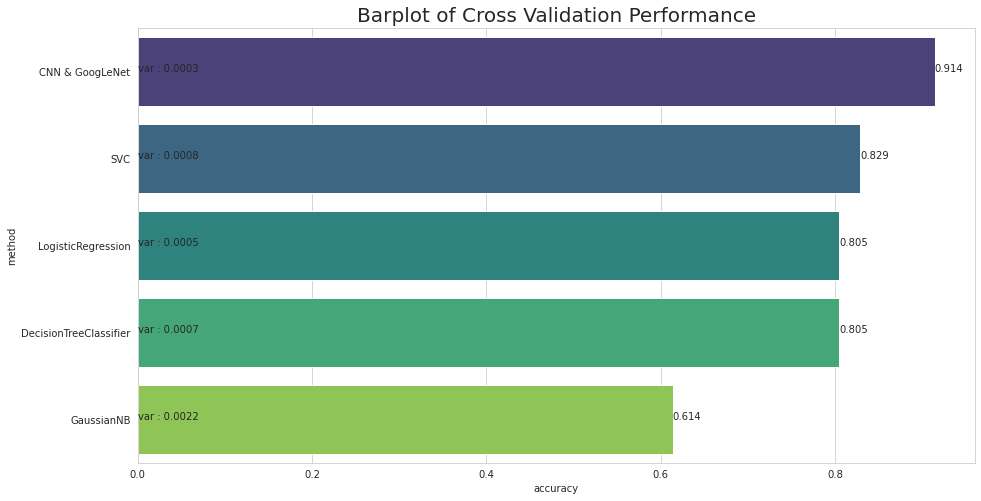

In [56]:
plt.figure(figsize = [15, 8])
sns.barplot(data = classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False),
            x = 'accuracy',
            y = 'method',
            palette = 'viridis')

for index, value in enumerate(classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['accuracy']) :
    plt.text(value, index, '%.3f'%value)
    
for index, value in enumerate(classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance']) :
    plt.text(0, index, 'var : ' + '%.4f'%value)
plt.title('Barplot of Cross Validation Performance', size = 20)

In [57]:
classifiers = [LogisticRegression(),
               GaussianNB(),
               SVC(),
               RandomForestClassifier(random_state = 2),
               DecisionTreeClassifier(random_state = 2)]
acc_score = []
conf_list = []
algos = []
for classifier in tqdm(classifiers) :
    model = classifier.fit(X_train_df,
                           y_train)
    pred = classifier.predict(X_val_df)
    algos.append(type(classifier).__name__)
    acc_score.append(accuracy_score(np.array(pred), np.array(y_val)))
    conf_list.append(list(confusion_matrix(np.array(pred), np.array(y_val))))
classifiers_df = pd.DataFrame({'method' : algos,
                               'accuracy' : acc_score,
                               'conf_list' : conf_list})

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [58]:
classifiers_df

,method,accuracy,conf_list
0,LogisticRegression,0.834101,"[[42, 5, 0, 1], [10, 43, 7, 0], [1, 7, 46, 1],..."
1,GaussianNB,0.603687,"[[29, 14, 0, 1], [16, 8, 1, 6], [6, 31, 52, 3]..."
2,SVC,0.811060,"[[42, 9, 0, 0], [7, 39, 8, 2], [2, 5, 46, 1], ..."
3,RandomForestClassifier,0.894009,"[[47, 9, 0, 0], [5, 44, 2, 0], [0, 1, 52, 1], ..."
4,DecisionTreeClassifier,0.774194,"[[38, 9, 0, 7], [11, 39, 4, 2], [1, 5, 49, 1],..."


In [59]:
classifiers = [LogisticRegression(),
               GaussianNB(),
               SVC(),
               RandomForestClassifier(random_state = 2),
               DecisionTreeClassifier(random_state = 2)]

cv_accuracy = []
cv_var = []
for classifier in tqdm(classifiers) :
    model = classifier.fit(X_train_df,
                           y_train)
    #pred = classifier.predict(X_val_df)
    #algos.append(type(classifier).__name__)
    #acc_score.append(accuracy_score(np.array(pred), np.array(y_val)))
    #conf_list.append(list(confusion_matrix(np.array(pred), np.array(y_val))))
    cv = cross_val_score(model,
                         X_train_df,
                         y_train,
                         scoring = 'accuracy',
                         cv = KFold(5))
    cv_accuracy.append(cv.mean())
    cv_var.append(cv.var())
classifiers_df_cv = pd.DataFrame({'method' : algos,
                                  'accuracy' : cv_accuracy,
                                  'conf_list' : cv_var})

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [60]:
#classifiers_df_cv
algos.append('CNN & GoogLeNet')
cv_accuracy.append(np.array([accuracy_score(np.array(res), np.array(y_val1)),
          accuracy_score(np.array(res2), np.array(y_val2)),
          accuracy_score(np.array(res3), np.array(y_val3)),
          accuracy_score(np.array(res4), np.array(y_val4)),
          accuracy_score(np.array(res5), np.array(y_val5))]).mean())

cv_var.append(np.array([accuracy_score(np.array(res), np.array(y_val1)),
          accuracy_score(np.array(res2), np.array(y_val2)),
          accuracy_score(np.array(res3), np.array(y_val3)),
          accuracy_score(np.array(res4), np.array(y_val4)),
          accuracy_score(np.array(res5), np.array(y_val5))]).var())

classifiers_df_cv = pd.DataFrame({'method' : algos,
                                  'accuracy' : cv_accuracy,
                                  'variance' : cv_var})

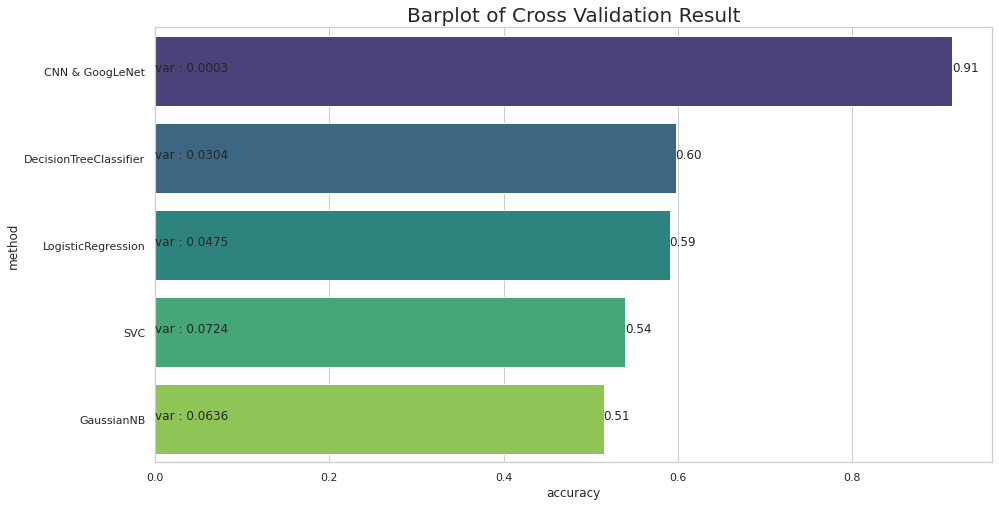

In [61]:
%matplotlib inline
sns.set()
plt.figure(figsize = [15, 8])
sns.set_style('whitegrid')
sns.barplot(data = classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False),
            x = 'accuracy',
            y = 'method',
            palette = 'viridis',
            ci = 'sd')

#labels = ['%.4f'%classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance'][5],
                     #'%.4f'%classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance'][4],
                     #'%.4f'%classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance'][0],
                     #'%.4f'%classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance'][2],
                     #'%.4f'%classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance'][1]]
#classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance'][0]


plt.title('Barplot of Cross Validation Result', size = 20)
#bars = [r for r in ax.get_children() if type(r)==Rectangle]
#colors = [c.get_facecolor() for c in bars[:-1]] # I think the last Rectangle is the background
for index, value in enumerate(classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['accuracy']) :
    plt.text(value, index, '%.2f'%value)

for index, value in enumerate(classifiers_df_cv.drop(3).sort_values(by = 'accuracy', ascending = False)['variance']) :
    plt.text(0, index, 'var : ' + '%.4f'%value)

In [62]:
classifiers = [LogisticRegression(),
               GaussianNB(),
               SVC(),
               RandomForestClassifier(random_state = 2),
               DecisionTreeClassifier(random_state = 2)]
algos = []
accuracy = []
for classifier in tqdm(classifiers) :
    algos.append(type(classifier).__name__)
    classifier.fit(X_train_df,
                   y_train)
    pred = classifier.predict(X_val_df)
    accuracy.append(accuracy_score(np.array(pred), y_val))
vis_df = pd.DataFrame({'method' : algos,
                       'accuracy' : accuracy})
vis_df

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,method,accuracy
0,LogisticRegression,0.834101
1,GaussianNB,0.603687
2,SVC,0.811060
3,RandomForestClassifier,0.894009
4,DecisionTreeClassifier,0.774194


In [63]:
#vis_df.append(pd.DataFrame(['CNN & GoogLeNet', 0.953917]), columns = ['method', 'accuracy'])
vis_df.append(pd.DataFrame({'method' : 'CNN & GoogLeNet',
                            'accuracy' : [0.953917]}))

,method,accuracy
0,LogisticRegression,0.834101
1,GaussianNB,0.603687
2,SVC,0.811060
3,RandomForestClassifier,0.894009
4,DecisionTreeClassifier,0.774194
0,CNN & GoogLeNet,0.953917


Text(0.5, 1.0, 'Classifiers Comparison on Validation Set')

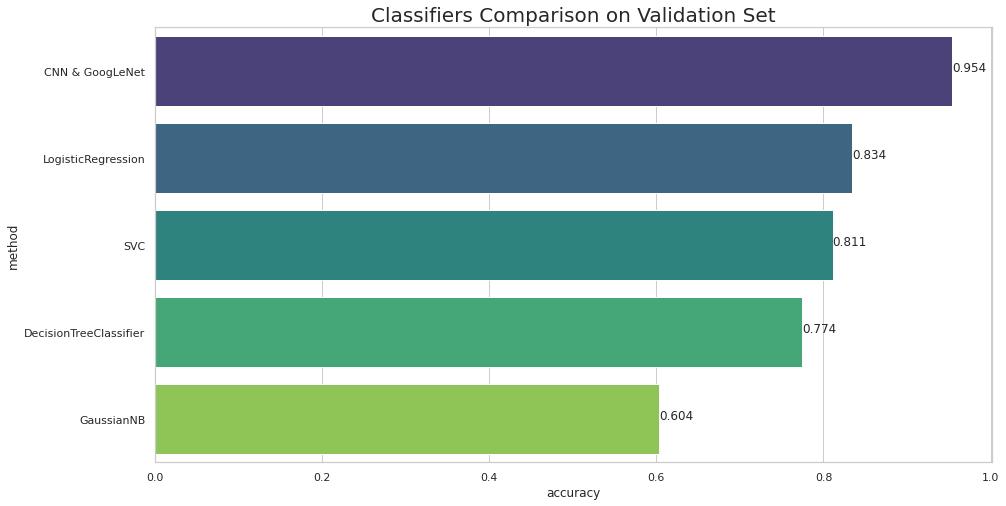

In [64]:
plt.figure(figsize = [15, 8])
sns.barplot(data = vis_df.append(pd.DataFrame({'method' : 'CNN & GoogLeNet',
                            'accuracy' : [0.953917]})).drop(3).sort_values(by = 'accuracy',
                                                                           ascending = False),
            x = 'accuracy',
            y = 'method',
            palette = 'viridis')
for index, value in enumerate(vis_df.append(pd.DataFrame({'method' : 'CNN & GoogLeNet',
                            'accuracy' : [0.953917]})).drop(3).sort_values(by = 'accuracy',
                                                                           ascending = False)['accuracy']) :
    plt.text(value, index, '%.3f'%value)
plt.title('Classifiers Comparison on Validation Set', size = 20)